# Assignment 1

Deadline: 19.03.2025, 12:00 CET

<Add your name, student-id and emal address>
* Zihan Liu, 22-736-938, zihan.liu@uzh.ch
* Yujie Tao, 23-744-378, yujie.tao@uzh.ch
* Weijie Chen, 23-743-727, weijie.chen@uzh.ch
* Schmidli Adrian, 17-728-833, adrian.schmidli@uzh.ch

In [1]:
# Import standard libraries
import os
import sys
import timeit # To compute runtimes
from typing import Optional

# Import third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local modules
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   # Change this path if needed
src_path = os.path.join(project_root, 'qpmwp-course\\src')
sys.path.append(project_root)
sys.path.append(src_path)
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.constraints import Constraints
from optimization.optimization import Optimization, Objective
from optimization.optimization_data import OptimizationData
from optimization.quadratic_program import QuadraticProgram, USABLE_SOLVERS

In [2]:
# Test data for the new functions in the class "ExpectedReturn"
df = pd.read_csv('c:/Users/admin\OneDrive/Dokumente/Studium UZH/Master/5. Semester/Quantitative Portfolio Management with Python/Assingments/1. Assingment/2. Werkstatt/qpmwp-course/data/msci_country_indices.csv',
                 index_col=0, header=0, parse_dates=True, date_format='%d-%m-%Y')
df = df.tail(10).iloc[:, :10]
print(df)
# df.to_csv('test.csv', index=False)

                  AT        AU        BE        CA        CH        DE  \
Index                                                                    
2023-04-05 -0.004435 -0.000488  0.005040 -0.005312  0.003285 -0.005872   
2023-04-06  0.010041 -0.001429  0.006269  0.001646  0.009571  0.004612   
2023-04-07  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2023-04-10  0.000000  0.000000  0.000000  0.003630  0.000000  0.000000   
2023-04-11  0.014592  0.013067 -0.000486  0.007168  0.003041  0.004867   
2023-04-12 -0.002488  0.004714 -0.012072  0.001708  0.000017  0.002662   
2023-04-13  0.001297 -0.003806 -0.000049  0.004728  0.000913  0.002400   
2023-04-14  0.009533  0.004829  0.007622  0.001950  0.008387  0.005797   
2023-04-17 -0.005665  0.003404  0.004917  0.003392 -0.001485 -0.002086   
2023-04-18  0.004836 -0.003262 -0.007127  0.002161  0.004373  0.006089   

                  DK        ES        FI        FR  
Index                                               
2023-

In [3]:
# Test of the new functions in the class "ExpectedReturn"
mu_1 = ExpectedReturn(method='geometric').estimate(df, inplace=False)
mu_2 = ExpectedReturn(method='arithmetic').estimate(df, inplace=False)
mu_3 = ExpectedReturn(method='harmonic').estimate(df, inplace=False)
mu_4 = ExpectedReturn(method='ewm', scalefactor=1, span=10, reverse=True).estimate(df, inplace=False)
print(mu_1)
print(mu_2)
print(mu_3)
print(mu_4)

AT    0.002751
AU    0.001692
BE    0.000394
CA    0.002102
CH    0.002804
DE    0.001840
DK    0.005431
ES    0.002810
FI    0.000145
FR    0.002552
dtype: float64
AT    0.002771
AU    0.001703
BE    0.000411
CA    0.002107
CH    0.002810
DE    0.001847
DK    0.005463
ES    0.002827
FI    0.000156
FR    0.002562
dtype: float64
AT    0.002730
AU    0.001681
BE    0.000377
CA    0.002098
CH    0.002798
DE    0.001834
DK    0.005399
ES    0.002793
FI    0.000135
FR    0.002543
dtype: float64
AT    0.002692
AU    0.001514
BE   -0.000321
CA    0.002683
CH    0.002701
DE    0.002629
DK    0.007262
ES    0.002627
FI   -0.000573
FR    0.003194
dtype: float64


## 1. Solver Horse Race

### 1.a)
(3 points)

Generate a Multivariate-Normal random dataset of dimension TxN, T=1000, N=100, and compute a vector of expected returns, q, and a covariance matrix, P, using classes ExpectedReturn and Covariance respectively.

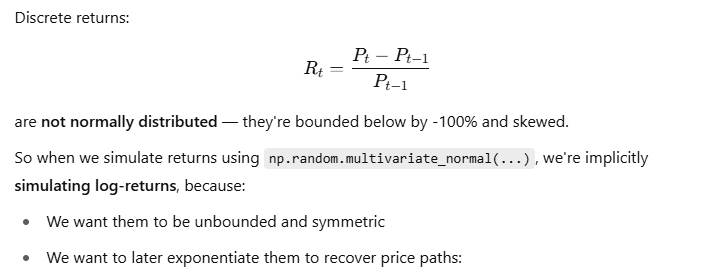
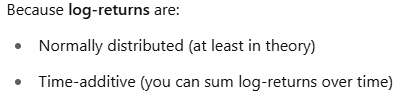
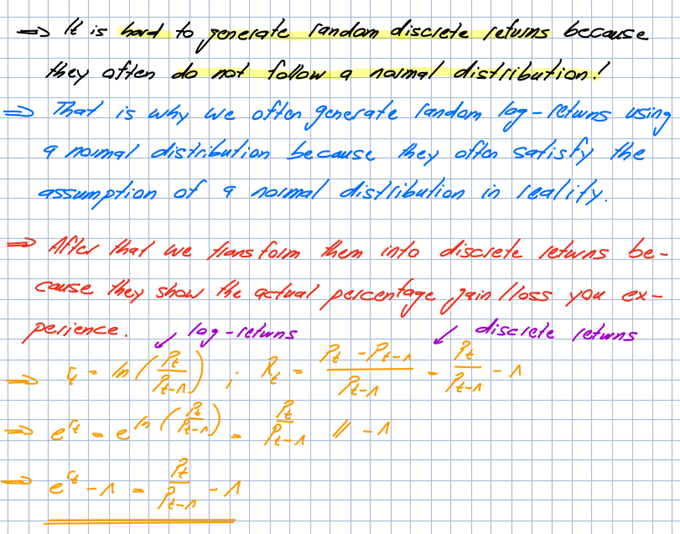

In [4]:
# Set the dimensions
T = 1000 # Number of time periods
N = 100 # Number of assets

# Generate a random mean vector and covariance matrix for the multivariate normal distribution
mean = np.random.randn(N)  # Random mean vector of size N
cov = np.random.randn(N, N)  # Random covariance matrix of size N x N
# np.random.randn is a NumPy function that generates samples from a standard normal distribution (mean = 0, standard deviation = 1)
def nearest_psd(A):
    B = (A + A.T) / 2 # Ensure symmetry
    eigenvalues, eigenvectors = np.linalg.eigh(B) # This function is used to compute the eigenvalues and eigenvectors of a symmetric (if real-valued and not complex) matrix B.
    # eigenvalues: a 1D NumPy array of the eigenvalues (real numbers, sorted in ascending order).
    # eigenvectors: a 2D NumPy array where each column is an eigenvector corresponding to the associated eigenvalue. That means the eigenvectors have to satisfy the equation: det(A−λI) = 0 (lambda is the eigenvalue).
    eigenvalues[eigenvalues < 0] = 0 # Set negative eigenvalues to zero because the covariance matrix must be positive semi-definite.
    return eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T # This is the formula for the eigenvalue decomposition of a symmetric matrix. That means this gives back the original matrix B if all eigenvalues are positive.
    # If some eigenvalues are negative, this expression returns a matrix that is the closest approximation to B, which satisfies the condition of being positive semi-definite.

cov = nearest_psd(cov)

# Generate the Multivariate-Normal random dataset
np.random.seed(7) # Set random seed for reproducibility
data = np.random.multivariate_normal(mean, cov, size=T) / 100 # Scale the data to represent returns
data = np.exp(data) - 1  # Convert to discrete returns

# Convert the dataset to a DataFrame for easier manipulation
df1 = pd.DataFrame(data, columns=[f'Asset_{i+1}' for i in range(N)])

# Compute the vector of expected returns (mean returns) from df1  
q_geometric = ExpectedReturn(method='geometric').estimate(df1, inplace=False)
q_arithmetic = ExpectedReturn(method='arithmetic').estimate(df1, inplace=False)
q_harmonic = ExpectedReturn(method='harmonic').estimate(df1, inplace=False)
q_ewm_bottom = ExpectedReturn(method='ewm', scalefactor=1, span=10, reverse=True).estimate(df1, inplace=False)
q_ewm_top = ExpectedReturn(method='ewm', scalefactor=1, span=10, reverse=False).estimate(df1, inplace=False)

# Compute the covariance matrix from df1
P = Covariance(method='pearson', check_positive_definite=False).estimate(df1, inplace=False)

# Display the results
print("Vector of expected returns (q_geometric):")
print(q_geometric)
print("\nVector of expected returns (q_arithmetic):")
print(q_arithmetic)
print("\nVector of expected returns (q_harmonic):")
print(q_harmonic)
print("\nVector of expected returns (q_ewm_bottom):")
print(q_ewm_bottom)
print("\nVector of expected returns (q_ewm_top):")
print(q_ewm_top)
print("\nCovariance matrix (P):")
print(P)

Vector of expected returns (q_geometric):
Asset_1      0.000965
Asset_2      0.003221
Asset_3      0.008826
Asset_4     -0.000481
Asset_5     -0.009110
               ...   
Asset_96    -0.005310
Asset_97    -0.018039
Asset_98     0.002601
Asset_99    -0.013785
Asset_100    0.020924
Length: 100, dtype: float64

Vector of expected returns (q_arithmetic):
Asset_1      0.001128
Asset_2      0.003373
Asset_3      0.008970
Asset_4     -0.000338
Asset_5     -0.008976
               ...   
Asset_96    -0.005205
Asset_97    -0.017861
Asset_98     0.002765
Asset_99    -0.013564
Asset_100    0.021035
Length: 100, dtype: float64

Vector of expected returns (q_harmonic):
Asset_1      0.000802
Asset_2      0.003069
Asset_3      0.008683
Asset_4     -0.000624
Asset_5     -0.009245
               ...   
Asset_96    -0.005415
Asset_97    -0.018216
Asset_98     0.002436
Asset_99    -0.014005
Asset_100    0.020812
Length: 100, dtype: float64

Vector of expected returns (q_ewm_bottom):
Asset_1     -0.009

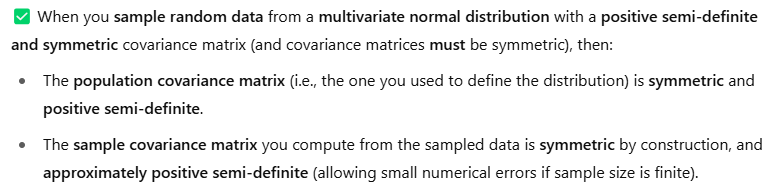

In [5]:
# Test if the statement above holds, because in this case we used a positive semi-definite covariance matrix to generate the data.

def is_positive_semi_definite(P):
    eigenvalues = np.linalg.eigvalsh(P) # Compute eigenvalues of the covariance matrix P.
    return np.all(eigenvalues >= 0) # Check if all eigenvalues are non-negative.

def is_symmetric(P):
    return np.allclose(P, P.T) # Check if the covariance matrix P is symmetric (A = A.T).

result_PSD = is_positive_semi_definite(P)
print("Is the matrix positive semi-definite:", result_PSD)
result_Sym = is_symmetric(P)
print("Is the matrix symmetric:", result_Sym)

Is the matrix positive semi-definite: True
Is the matrix symmetric: True


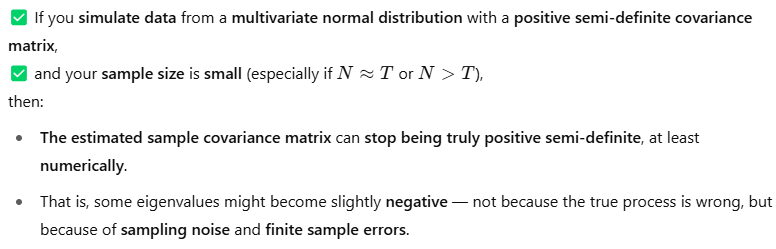
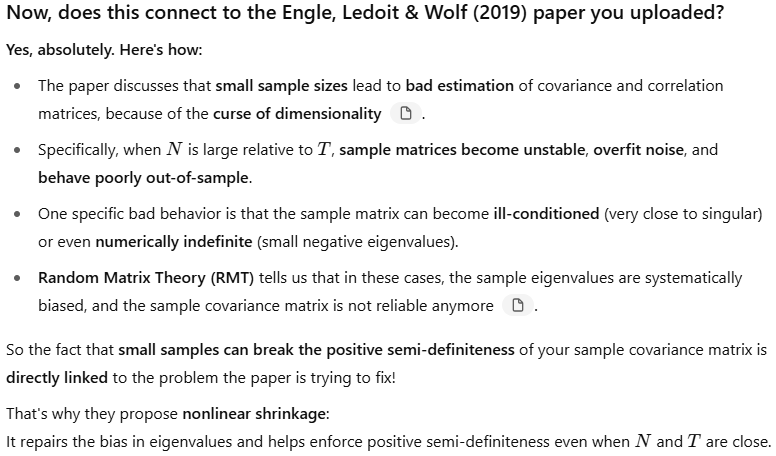

Just some ideas for the group presentation in the lecture "Optimization Methods in Finance".
Linkage from the relevant paper to the code provided above.
Additionally, it would be possible to add an out-of-sample performance test to underline the statements of the paper.
Furthermore, it would be nice to show the development of the eigenvalues in a nice plot to visualize it a bit better.
Implementation of the non-linear shrinkage method in the class "covariance". Using the already existent MatLab Code from Florian and transform into python.

### 1.b)
(3 points)

Instantiate a constraints object by injecting column names of the data created in 1.a) as ids and add:
- a budget constaint (i.e., asset weights have to sum to one)
- lower bounds of 0.0 for all assets
- upper bounds of 0.2 for all assets
- group contraints such that the sum of the weights of the first 30 assets is <= 0.3, the sum of assets 31 to 60 is <= 0.4 and the sum of assets 61 to 100 is <= 0.5

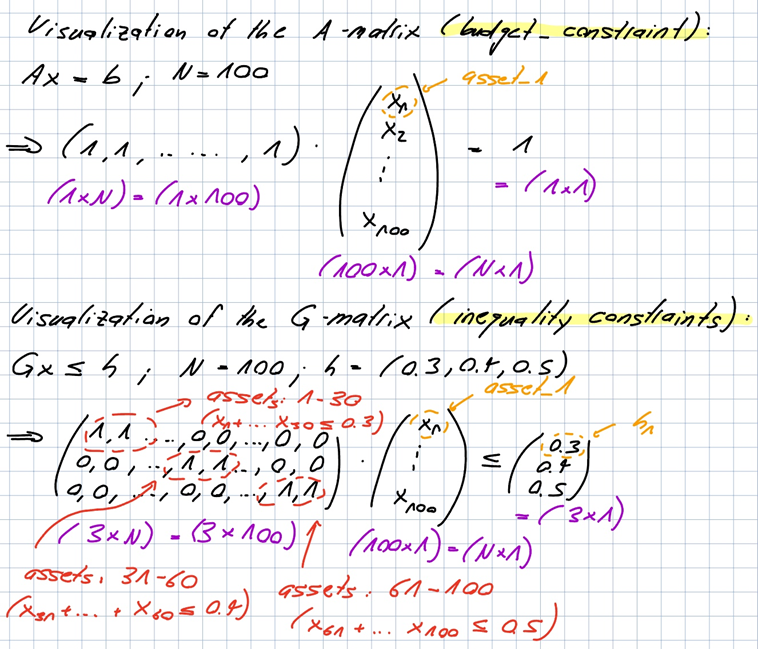

In [21]:
# Instantiate the Constraints class
constraints = Constraints(ids = df1.columns.tolist()) # It gives you a Python list of the column names from the pandas DataFrame df1 and assigns it to the ids attribute of the class "Constraints".
# Now you have to use the constructed class "constraints" to add constraints to the optimization problem.

# Add budget constraint
constraints.add_budget() # Nothing has to be specified within the function because we just use the default values (i.e., it is as equality constraint and the b-vector (here just a scalar) is 1).
# Remark: The function is written like this the b-vector ("rhs") is just a scalar and the A-matrix ("Amat") is just a matrix with one row of ones and and n columns. So there is just one equality constraint (budget constraint).
# If we would like to add a different equality constraint to the A-matrix ("Amag") and b-vector ("rhs"), we have to adjust the function within the class "Constraints".

# Add box constraints (i.e., lower and upper bounds)
constraints.add_box(lower=0.0, upper=0.2) # "box_type" is by default "LongOnly". 
# The function "add_box" sets just the lower and upper bounds for the box constraints as equality constraints. Afterwards the solver interprets these as inequality constraints.
# Simply generates two vectors of the same size as the number of assets (N) with the lower and upper bounds for each asset.

# Add linear constraints
G = pd.DataFrame([pd.Series(1, index=range(0, 30)), pd.Series(1, index=range(30, 60)), pd.Series(1, index=range(60, 100))])
G.columns = constraints.ids
h = pd.Series([0.3, 0.4, 0.5])
constraints.add_linear(G=G, sense='<=', rhs=h)

# Visualize the constraints
print(constraints.ids) # Print the ids of the class "Constraints".
print(constraints.budget)
print(constraints.box)
print(constraints.linear)

['Asset_1', 'Asset_2', 'Asset_3', 'Asset_4', 'Asset_5', 'Asset_6', 'Asset_7', 'Asset_8', 'Asset_9', 'Asset_10', 'Asset_11', 'Asset_12', 'Asset_13', 'Asset_14', 'Asset_15', 'Asset_16', 'Asset_17', 'Asset_18', 'Asset_19', 'Asset_20', 'Asset_21', 'Asset_22', 'Asset_23', 'Asset_24', 'Asset_25', 'Asset_26', 'Asset_27', 'Asset_28', 'Asset_29', 'Asset_30', 'Asset_31', 'Asset_32', 'Asset_33', 'Asset_34', 'Asset_35', 'Asset_36', 'Asset_37', 'Asset_38', 'Asset_39', 'Asset_40', 'Asset_41', 'Asset_42', 'Asset_43', 'Asset_44', 'Asset_45', 'Asset_46', 'Asset_47', 'Asset_48', 'Asset_49', 'Asset_50', 'Asset_51', 'Asset_52', 'Asset_53', 'Asset_54', 'Asset_55', 'Asset_56', 'Asset_57', 'Asset_58', 'Asset_59', 'Asset_60', 'Asset_61', 'Asset_62', 'Asset_63', 'Asset_64', 'Asset_65', 'Asset_66', 'Asset_67', 'Asset_68', 'Asset_69', 'Asset_70', 'Asset_71', 'Asset_72', 'Asset_73', 'Asset_74', 'Asset_75', 'Asset_76', 'Asset_77', 'Asset_78', 'Asset_79', 'Asset_80', 'Asset_81', 'Asset_82', 'Asset_83', 'Asset_84', 

### 1.c) 
(4 points)

Solve a Mean-Variance optimization problem (using coefficients P and q in the objective function) which satisfies the above defined constraints.
Repeat the task for all open-source solvers in qpsolvers and compare the results in terms of:

- runtime
- accuracy: value of the primal problem.
- reliability: are all constarints fulfilled? Extract primal resisduals, dual residuals and duality gap.

Generate a DataFrame with the solvers as column names and the following row index: 'solution_found': bool, 'objective': float, 'primal_residual': float, 'dual_residual': float, 'duality_gap': float, 'runtime': float.

Put NA's for solvers that failed for some reason (e.g., unable to install the package or solvers throws an error during execution). 




In [ ]:
# Extract the constraints in the format required by the solver (without lower and upper bounds)
GhAb = constraints.to_GhAb()
# print(GhAb)
# The lower and upper bounds are not included in the GhAb object. The lower and upper bounds are stored in the box attribute of the class "constraints" and will be added later.

# Loop over solvers, instantiate the quadratic program, solve it and store the results





{'G': array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

Print and visualize the results

In [5]:
#<your code here>

## 2. Analytical Solution to Minimum-Variance Problem

(5 points)

- Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
- Implement the `solve` method in `MinVariance` such that if `solver_name = 'analytical'`, the analytical solution is computed and stored within the object (if such a solution exists). If not, call the `solve` method from the parent class.
- Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
- Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
- Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
- Solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).


In [ ]:
# Define class MinVariance
class MinVariance(Optimization):

    def __init__(self,
                 constraints: Constraints,
                 covariance: Optional[Covariance] = None,
                 **kwargs):
        super().__init__(
            constraints=constraints,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance

    def set_objective(self, optimization_data: OptimizationData) -> None:
        #<your code here>

    def solve(self) -> None:
        if self.params.get('solver_name') == 'analytical':
            #<your code here>
            return None
        else:
            return super().solve()


# Create a constraints object with just a budget constraint
#<your code here>

# Instantiate the MinVariance class
#<your code here>

# Prepare the optimization data and prepare the optimization problem
#<your code here>

# Solve the optimization problem and print the weights
#<your code here>